In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import signal
import skimage
from PIL import Image, ImageOps

In [ ]:
# QUESTION 1

# "The exponent n in V1 neurons is generally between 1.0 and 3.5, with an average of about 2"

def normalization(image, gamma, sigma, n, norm_pool_size):

    normed_image = np.zeros(image.shape)
    min_norm = norm_pool_size//2
    max_norm = min(image.shape[0], image.shape[1]) -norm_pool_size//2

    for i in range(min_norm, max_norm+1):
        for j in range(min_norm, max_norm+1):
            pixel = image[i, j]
            norm_pool = image[i-norm_pool_size//2:i+norm_pool_size//2, 
                              j-norm_pool_size//2:j+norm_pool_size//2]
            normed_image[i,j] = gamma * pixel**n / (sigma**n + np.sum(norm_pool**n))

    normed_image = normed_image[min_norm:max_norm+1, min_norm:max_norm+1]
    unnormed_image = image[min_norm:max_norm+1, min_norm:max_norm+1]

    return normed_image, unnormed_image
'''
# replaced this because the normalization pool was the whole image for every pixel
def normalization(D, gamma, sigma, n=1):

  normalization_pool = np.sum(D**n)
  normalized_response = gamma * D**n / ((sigma**n) + (normalization_pool))

  return normalized_response
'''

'\n# replaced this because the normalization pool was the whole image for every pixel\ndef normalization(D, gamma, sigma, n=1):\n\n  normalization_pool = np.sum(D**n)\n  normalized_response = gamma * D**n / ((sigma**n) + (normalization_pool))\n\n  return normalized_response\n'

In [ ]:
# Get an image from skimage as the stimulus
'''
x = skimage.data.camera() # camera, checkerboard, clock, coins, grass, gravel, page, blobs, text, brick, binary blobs # alternative grayscale images
'''
# Or upload your own image
image = Image.open('rainforest.jpg')
image_grey = ImageOps.grayscale(image)
x = np.array(image_grey)
print(x.shape)

# subsample to h x w
i,j = x.shape[0]//2, x.shape[1]//2
h, w = 800, 800
x = x[i-h//2:i+h//2, j-w//2:j+w//2]

print(x.max(), x.min())
print("Shape of the image:", x.shape)

# Normalize the image
normed_x,  unnormed_x = normalization(x, gamma=5, sigma=300, n=2, norm_pool_size=10)
print(normed_x.max(), normed_x.min())
print(unnormed_x.shape, normed_x.shape)

# Convert normed_x values back to the range of pixel intensites [0 255] before displaying
normed_x_plot = np.floor( normed_x * (x.max() - x.min())/(normed_x.max() - normed_x.min()) ).astype(np.uint8)
print(normed_x_plot.max(), normed_x_plot.min())

(958, 1440)
255 0
Shape of the image: (800, 800)
3.5614683963566107 0.0
(791, 791) (791, 791)
255 0


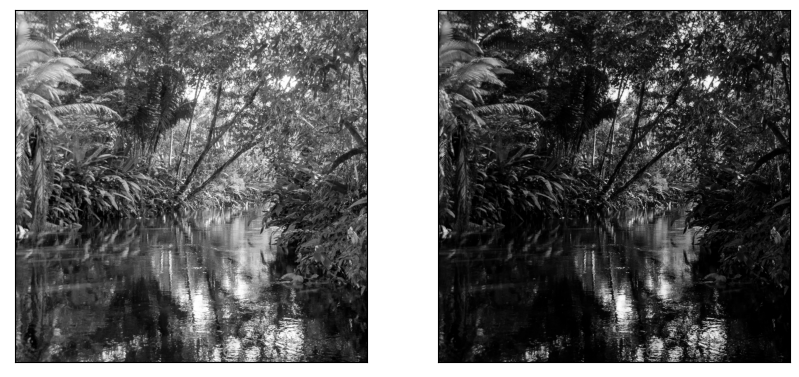

In [ ]:
# Plot comparison

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(unnormed_x, cmap='gray', vmin=0, vmax=255)
ax[1].imshow(normed_x_plot, cmap='gray', vmin=0, vmax=255)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
plt.savefig(f'./original_v_normed_rainforest_{h}.png')

In [ ]:
# spatial autocorrelation
# Based on: Simoncelli and Olhausen 2001, Reinagel and Zador 1999

def two_pt_corr(image, patch_size): # square patch (patch_size x patch_size), nonoverlapping patches

  patches = []
  for ki in range(image.shape[0]//patch_size):
    for kj in range(image.shape[1]//patch_size):
      patches.append(image[ki*patch_size:(ki+1)*patch_size, \
                           kj*patch_size:(kj+1)*patch_size].flatten())
  N_patches = len(patches)
  patches = np.array(patches) # shape N_patches x patch_size**2

  I_c = np.tile(np.mean(patches, axis=0), N_patches).reshape(patches.shape)
  centered_patches = patches - I_c

  rho = np.sqrt(centered_patches.T @ centered_patches)/N_patches
  rho /= rho[patch_size**2//2, patch_size**2//2] # normalize by autocorrelation of the central pixel in the patches

  return rho

# to recover the patch pixel locations corresponding to the rows & cols of the autocorrelation matrix:
def get_patch_coords(patch_size):

  patch_coords = []
  for i in range(patch_size):
    for j in range(patch_size):
      patch_coords.append((i, j))

  return patch_coords

# calculate autocorrelation vs. distance

def autocorr_vs_dist(spatialAC_mat, patch_coords):

  patch_coords = np.array(patch_coords)
  dists_sq = np.zeros(spatialAC_mat.shape)

  for p in range(patch_coords.shape[0]):
    pixel = patch_coords[p]

    for i in range(patch_coords.shape[0]):
      diff = pixel - patch_coords[i]
      dists_sq[p, i] = np.dot(diff, diff)

  dsq_unique = np.unique(dists_sq, return_inverse=True)
  mean_ACs = np.zeros(dsq_unique[0].shape[0])
  flat_AC_mat = spatialAC_mat.flatten()

  for i in range(dsq_unique[0].shape[0]):
    flatinds = np.where(dsq_unique[1]==i)[0]
    mean_ACs[i] = np.mean(flat_AC_mat[flatinds])

  distances = np.sqrt(dsq_unique[0])

  return distances, mean_ACs


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


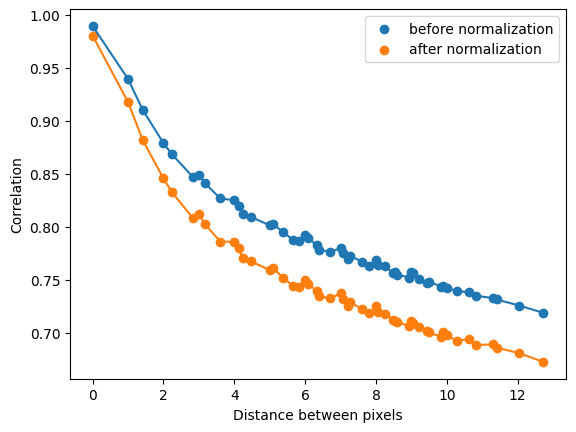

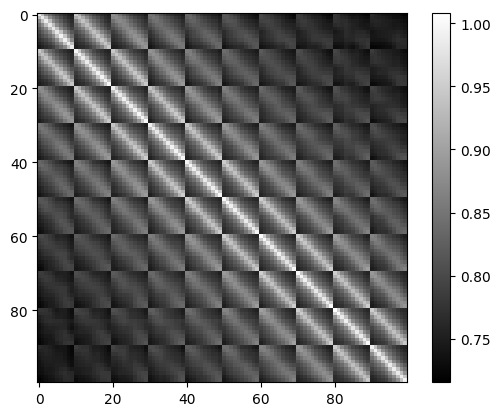

In [ ]:
# plot autocorrelation vs distance

patch_size = 10 # increase patch size to get more distances
spatialAC1 = two_pt_corr(unnormed_x, patch_size)
spatialAC2 = two_pt_corr(normed_x, patch_size)
patch_coords = get_patch_coords(patch_size)

dists, ACs1 = autocorr_vs_dist(spatialAC1, patch_coords)
dists, ACs2 = autocorr_vs_dist(spatialAC2, patch_coords)

plt.scatter(dists, ACs1, label='before normalization')
plt.plot(dists, ACs1)
plt.scatter(dists, ACs2, label='after normalization')
plt.plot(dists, ACs2)
plt.xlabel('Distance between pixels')
plt.ylabel('Correlation')
plt.legend()
plt.savefig(f'./rainforest{h}_SAC_patchsz{patch_size}.png', dpi=300)

plt.figure()
plt.imshow(spatialAC1, cmap='gray')
plt.colorbar()
print(patch_coords)

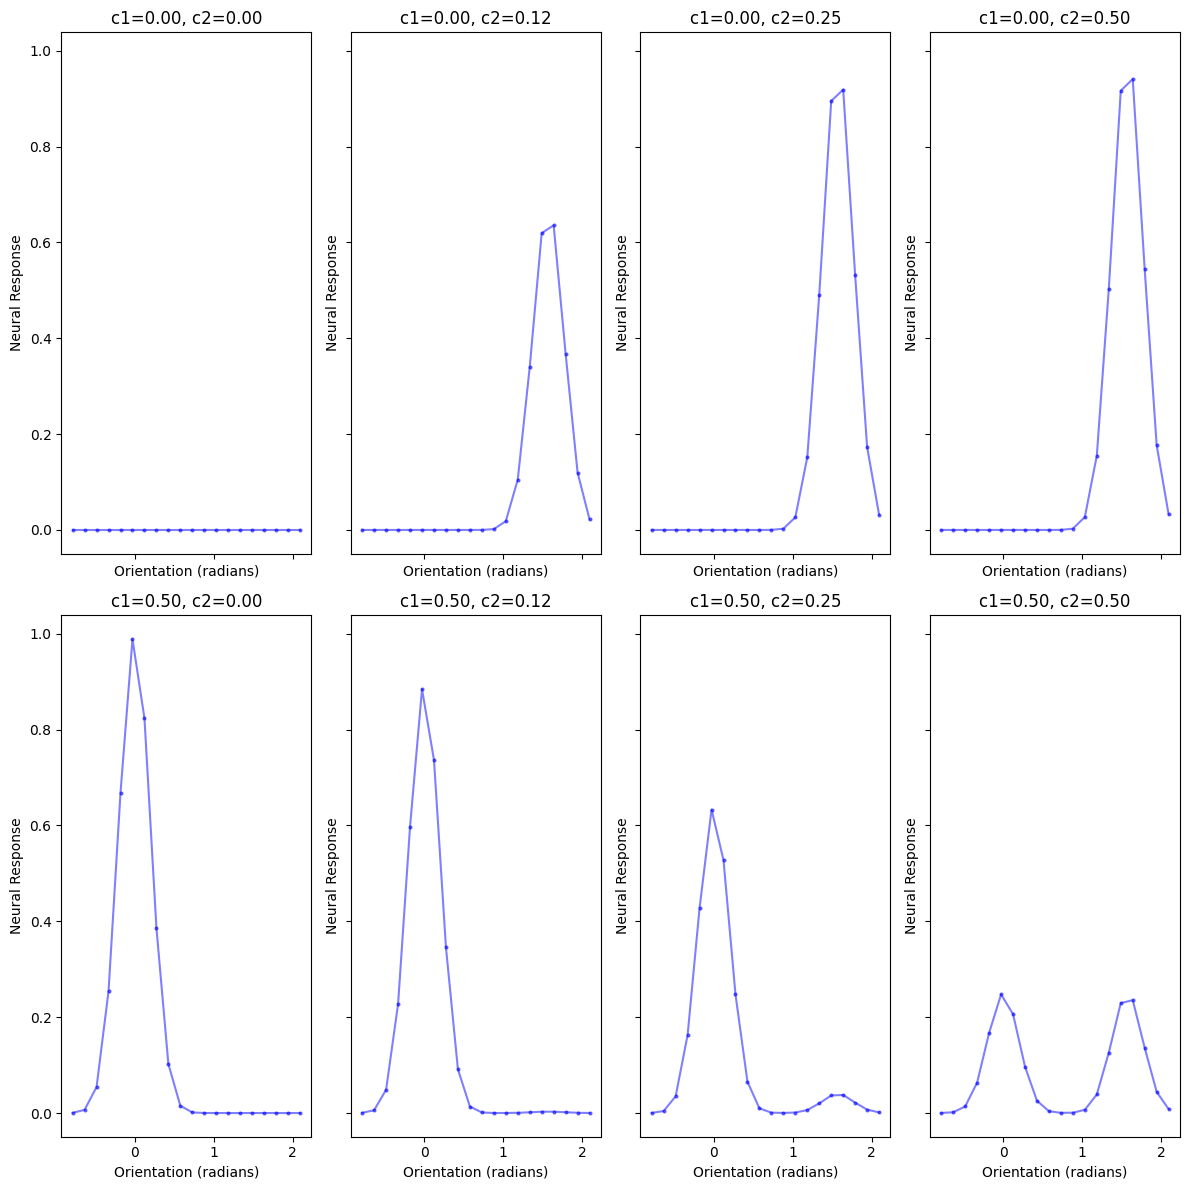

In [ ]:
# QUESTION 2
# Winner-take-all competition

import numpy as np
import matplotlib.pyplot as plt

# Define constants
r_max = 1
c_50 = 0.1
n = 4
num_neurons = 20
sigma = .2  # Standard deviation

# Define stimulus orientations and contrast levels
vertical_orientations = np.pi / 2
horizontal_orientations = 0
c1_contrasts = np.array([0, .5])
c2_contrasts = np.array([0, .12, .25, .50])

# Define Gaussian functions
x_values = np.linspace(-np.pi / 4, 2 * np.pi / 3, num_neurons)
g2 = np.exp(-(x_values - horizontal_orientations) ** 2 / (2 * sigma ** 2))  # Centered at 0 for horizontal orientation
g1 = np.exp(-(x_values - vertical_orientations) ** 2 / (2 * sigma ** 2))  # Centered at pi/2 for vertical orientation

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 12), sharex=True, sharey=True)

# Calculate and plot responses
for i in range(2):
    for j in range(4):
        c1 = c1_contrasts[i]
        c2 = c2_contrasts[j]

        # Calculate response
        response = r_max * ((c1 ** n * g2) + (c2 ** n * g1)) / \
                   (c_50 ** n + np.sqrt((c1 ** 2) + (c2 ** 2)) ** n)

        # Plot response
        axs[i, j].plot(x_values, response, color='blue', alpha=0.5, marker='o', markersize=2)
        axs[i, j].set_title(f'c1={c1:.2f}, c2={c2:.2f}')
        axs[i, j].set_xlabel('Orientation (radians)')
        axs[i, j].set_ylabel('Neural Response')

plt.tight_layout()
plt.show()


In [ ]:
# QUESTION 3
# Eq 12 Carandini & Heeger

def adapt_norm_eq12(I, W, Alpha, gamma, beta, sigma, n, m, p):
  """
  I: kxk-dim arr, activities of afferent neurons
  W: kxk-dim arr, weights––summation field of neuron j
  Alpha: kxk-dim arr, weights––suppressive field of neuron j
  gamma: const
  beta: const, baseline response
  sigma:const
  n, m, p: const, exponents
  """
  WI = np.dot(W.flatten(), I.flatten())
  AlphaIm = np.dot(Alpha.flatten(), I.flatten()**m)
  R = gamma * (WI**n + beta) / (sigma**n + AlphaIm**p)

  return R

In [ ]:
bg_intensities = [0.01, 0.2, 0.5, 0.9] # [10**i for i in [0.1, 0.3, 0.5, 0.7]]
sq_intensities = [10**i for i in np.arange(-1.1, 2, 0.1)]

bg_size = 20
sq_size = 4

# W and Alpha: normal distribution where x is distance from center, Alpha variance > W variance
W = np.zeros((bg_size, bg_size))
Alpha = np.zeros((bg_size, bg_size))
varW = 3
varAlpha = 9
center = np.array([bg_size//2, bg_size//2])

for i in range(bg_size): # there's probably a better way to do this
    for j in range(bg_size):
        pixel = np.array([i, j])
        dist2center = np.linalg.norm(center-pixel)
        W[i, j] = np.exp(-0.5 * dist2center**2/varW)
        Alpha[i, j] = np.exp(-0.5 * dist2center**2/varAlpha)

W /= np.max(W)
Alpha /= np.max(Alpha)

gamma = 2
beta = 0.2
sigma = 8
n = 2.5
m = 1
p = 2.5

responses = []

for bi in bg_intensities:
  for si in sq_intensities:

    # generate a stimulus with a square patch on a background of a different intensity
    bg_intensity = bi
    sq_intensity = si

    I = bg_intensity * np.ones((bg_size, bg_size))
    I[(bg_size-sq_size)//2:(bg_size+sq_size)//2, (bg_size-sq_size)//2:(bg_size+sq_size)//2] = sq_intensity

    # plt.imshow(I, cmap='gray', vmin=0, vmax=1)
    
    R = adapt_norm_eq12(I, W, Alpha, gamma=gamma, beta=beta, sigma=sigma, n=n, m=m, p=p)

    responses += [R]

responses = np.array(responses).reshape(len(bg_intensities), len(sq_intensities))

In [ ]:
responses.shape

(4, 31)

0.01
0.2
0.5
0.9


Text(0.5, 0, 'Stimulus Intensity (log10 scale)')

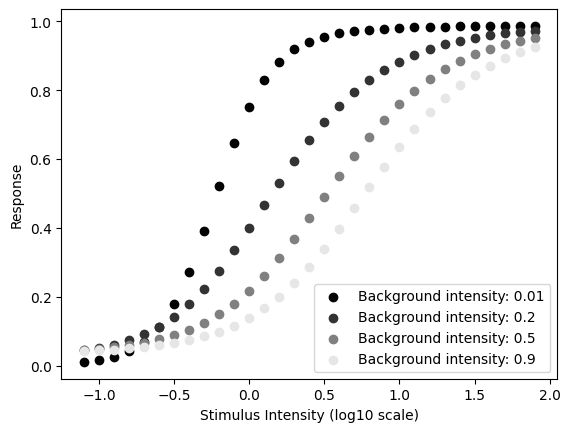

In [ ]:
for i, bi in enumerate(bg_intensities):
    print(bi)
    color = str(bi) # str(np.log(bi)/np.log(max(bg_intensities)))
    plt.scatter(np.log10(sq_intensities), responses[i], color=color, label=f'Background intensity: {bi}')
plt.legend()
plt.ylabel('Response')
plt.xlabel('Stimulus Intensity (log10 scale)')

In [ ]:
# contrast increase 
sq_intensity = 0.8
bg_intensity = 0.7
I = bg_intensity * np.ones((bg_size, bg_size))
I[(bg_size-sq_size)//2:(bg_size+sq_size)//2, (bg_size-sq_size)//2:(bg_size+sq_size)//2] = sq_intensity


bg_intensity = 0.1
I2 = bg_intensity * np.ones((bg_size, bg_size))
I2[(bg_size-sq_size)//2:(bg_size+sq_size)//2, (bg_size-sq_size)//2:(bg_size+sq_size)//2] = sq_intensity

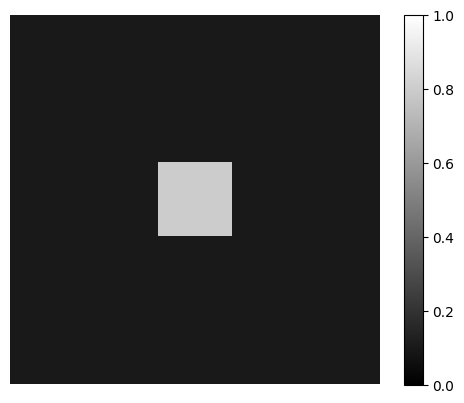

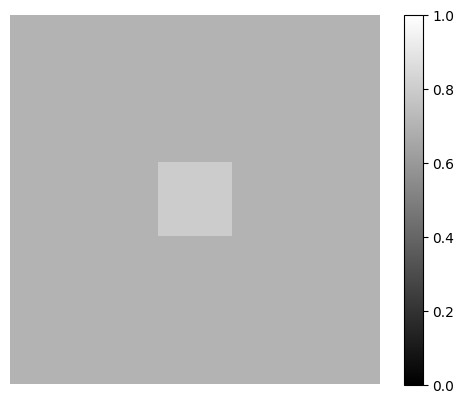

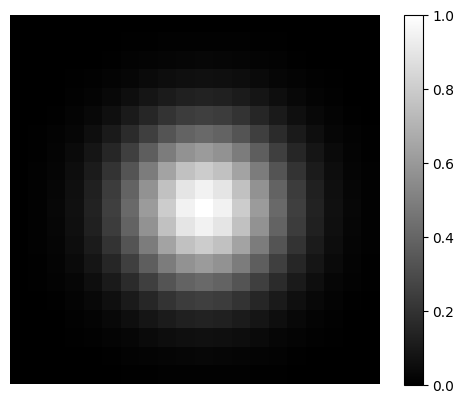

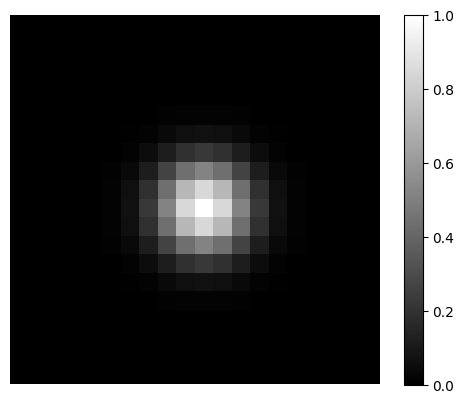

In [ ]:
plt.imshow(I2, cmap='gray', vmax=1, vmin=0)
plt.colorbar()
plt.axis('off')
plt.show()
plt.imshow(I, cmap='gray', vmax=1, vmin=0)
plt.colorbar()
plt.axis('off')
plt.show()
plt.imshow(Alpha, cmap='gray', vmax=1, vmin=0)
plt.colorbar()
plt.axis('off')
plt.show()
plt.imshow(W, cmap='gray', vmax=1, vmin=0)
plt.colorbar()
plt.axis('off')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3569eb68-a6a6-4122-9c3d-498e88f49235' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>